# Transfer Learning

Inspired by: https://github.com/openai/openai-cookbook/blob/main/examples/Customizing_embeddings.ipynb

In [3]:
# imports
from typing import List, Tuple  # for type hints

import numpy as np  # for manipulating arrays
import pandas as pd  # for manipulating data in dataframes
import pickle  # for saving the embeddings cache
import plotly.express as px  # for plots
import random  # for generating run IDs
from sklearn.model_selection import train_test_split  # for splitting train & test data
import torch  # for matrix optimization

import datasets

from mteb import MTEB

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


## 1. Load and process input data

In [4]:
def load_dataset_for_task(task_name: str, split: str = 'train'):
    mteb = MTEB(tasks=[task_name], task_langs=["en"])
    task = mteb.tasks[0]
    task.load_data()
    assert task.data_loaded, "Data was not loaded"
    return task.dataset[split] # Have form train, validation, test (test is used for MTEB)

def process_dataset(dataset: datasets.Dataset) -> pd.DataFrame:
    train_df = dataset.to_pandas()
    train_df = train_df[['sentence1', 'sentence2', 'score']]
    def normalize(x, min_score, max_score): # Normalise between 0 and 1 (Maybe better to do -1 and 1)
        return (x - min_score) / (max_score - min_score)
    train_df['score'] = normalize(train_df['score'], train_df['score'].min(), train_df['score'].max())
    return train_df

In [5]:
task_name = "STSBenchmark"
train_dataset = load_dataset_for_task(task_name, split='train')
val_dataset = load_dataset_for_task(task_name, split='validation')

df_train = process_dataset(train_dataset)
df_val = process_dataset(val_dataset)

df_train.head()

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,1.00
1,A man is playing a large flute.,A man is playing a flute.,0.76
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76
3,Three men are playing chess.,Two men are playing chess.,0.52
4,A man is playing the cello.,A man seated is playing the cello.,0.85


## 2. Generate Synthetic Data

In [87]:
# TODO (Look at generating for dismilliar data cause all of them seem to be simialr)

## 3. Get Embeddings and Cosine Similarities

In [6]:
from model_factory import model_factory
model_name = 'voyage'

In [7]:
def generate_embedding(df: pd.DataFrame, model_name: str, task_name: str):
    model = model_factory(model_name, task_name)
    for column in ['sentence1', 'sentence2']:
        df[f"{column}_embedding"] = model.encode(df[column].tolist())

def get_cosine_similarity(a: np.array, b: np.array):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def generate_cosine_similarity(df: pd.DataFrame):
    df['cosine_similarity'] = df.apply(lambda x: get_cosine_similarity(x['sentence1_embedding'], x['sentence2_embedding']), axis=1)

In [8]:
generate_embedding(df_train, model_name, task_name)
generate_embedding(df_val, model_name, task_name)

generate_cosine_similarity(df_train)
generate_cosine_similarity(df_val)

df_train.head()

Loading voyage from cache for STSBenchmark...
Loading voyage from cache for STSBenchmark...


,sentence1,sentence2,score,sentence1_embedding,sentence2_embedding,cosine_similarity
0,A plane is taking off.,An air plane is taking off.,1.00,"[-0.009499897180926493, 0.0301658415866585, 0....","[-0.0071485294876617094, 0.026777316202289493,...",0.989618
1,A man is playing a large flute.,A man is playing a flute.,0.76,"[-0.05704887022457301, 0.062293174230553326, 0...","[-0.061399369301635476, 0.05968738972087922, 0...",0.984086
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76,"[-0.04560167076112836, 0.03845534935758576, 0....","[-0.037441772156281646, 0.037778244107429276, ...",0.988618
3,Three men are playing chess.,Two men are playing chess.,0.52,"[-0.02487597662154204, 0.03249265444987086, -0...","[-0.027216117206502882, 0.045537488747252275, ...",0.948362
4,A man is playing the cello.,A man seated is playing the cello.,0.85,"[-0.05514069845318368, 0.04386556755319591, 0....","[-0.06483882233777385, 0.053375318816676315, 0...",0.973424


## 4. Evaluate The Baseline Performance

We use spearman and Pearson to evaluate the performance. 

Pearson correlation is a measure of strength of linear relationship between two variables. It ranges from -1 to 1.

While spearman correlation is a measure of monotonic relationship between two variables. It ranges from -1 to 1.

We want both these values to be close to 1. 


In [41]:
def get_correlation(df: pd.DataFrame, column_name: str = 'cosine_similarity'):
    return df[column_name].corr(df['score'], method='spearman'), df[column_name].corr(df['score'], method='pearson')

spearmans, pearsons = get_correlation(df_train)
print(f"Train: Spearman: {spearmans}, Pearson: {pearsons}")

spearmans, pearsons = get_correlation(df_val)
print(f"Validation: Spearman: {spearmans}, Pearson: {pearsons}")

Train: Spearman: 0.8242663753045756, Pearson: 0.8401670379894389
Validation: Spearman: 0.8589175713958699, Pearson: 0.8550142024656555


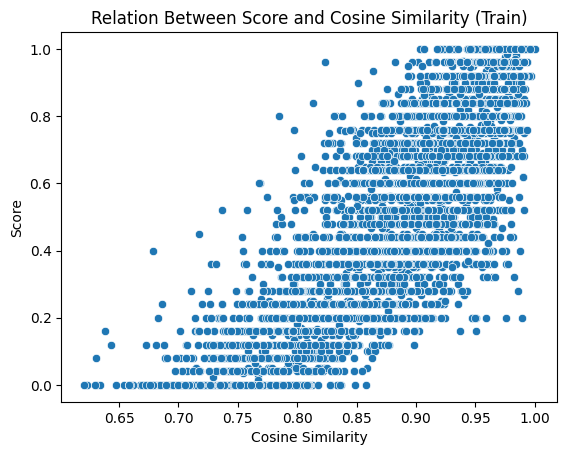

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df: pd.DataFrame, title: str):
    sns.scatterplot(data=df, x='cosine_similarity', y='score')
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Score')
    plt.show()

plot_correlation(df_train, 'Relation Between Score and Cosine Similarity (Train)')

# 5. Transfer Learning

In [44]:
def optimize_matrix(
    new_length: int = 2048,
    batch_size: int = 200,
    max_epochs: int = 100,
    lr: float = 100,
    p: float = 0.1,
    print_every: int = 10,
):
    def get_tensors(df):
        df_x1 = np.stack(df['sentence1_embedding'].values)
        df_x2 = np.stack(df['sentence2_embedding'].values)
        df_y = df['score'].values


        X1 = torch.from_numpy(df_x1).float()
        X2 = torch.from_numpy(df_x2).float()
        Y = torch.from_numpy(df_y).float()
        return X1, X2, Y

    X1_train, X2_train, Y_train = get_tensors(df_train)
    X1_val, X2_val, Y_val = get_tensors(df_val)

    train_dataset = torch.utils.data.TensorDataset(X1_train, X2_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    def model(X1, X2, matrix, p=p):
        e1 = torch.nn.functional.dropout(X1, p=p)
        e2 = torch.nn.functional.dropout(X2, p=p)
        return torch.nn.functional.cosine_similarity(e1 @ matrix, e2 @ matrix)
    
    def mse_loss(predictions, targets):
        real_preds = torch.clamp(2*(predictions - 0.5), 0, 1)
        return torch.nn.functional.mse_loss(real_preds, targets)

    def calc_custom(embedding, matrix):
        embedding_tensor = torch.from_numpy(embedding).float()
        modified_embedding = embedding_tensor @ matrix
        return modified_embedding.detach().numpy()

    epochs, types, losses, accuracies, matrices = [], [], [], [], []

    matrix = torch.randn(len(df_train['sentence1_embedding'].values[0]), new_length, requires_grad=True)

    for epoch in range(max_epochs):
        epoch_loss = 0
        for X1, X2, Y in train_loader:
            predictions = model(X1, X2, matrix)
            loss = mse_loss(predictions, Y)
            loss.backward()
            with torch.no_grad():
                matrix -= lr * matrix.grad
                matrix.grad.zero_()
            epoch_loss += loss.item()
        
        with torch.no_grad():
            test_preds = model(X1_val, X2_val, matrix)
            test_loss = mse_loss(test_preds, Y_val)
        
        for df in [df_train, df_val]:
            m = matrix.clone().detach().numpy()
            df["custom_1"] = df['sentence1_embedding'].apply(lambda x: calc_custom(x, matrix))
            df["custom_2"] = df['sentence2_embedding'].apply(lambda x: calc_custom(x, matrix))
            df["custom_cosine_similarity"] = df.apply(lambda x: get_cosine_similarity(x['custom_1'], x['custom_2']), axis=1)

            spearmans, _ = get_correlation(df, 'custom_cosine_similarity')
            type = "train" if df is df_train else "val"
            l = loss.item() if df is df_train else test_loss.item()
            accuracies.append(spearmans)
            losses.append(l)
            types.append(type)
            epochs.append(epoch)
            matrices.append(m)

            if print_every and epoch % print_every == 0:
                print(f"Epoch {epoch+1}/{max_epochs} ({type}) - Loss: {l}, Spearman: {spearmans}")

            
    data = pd.DataFrame({
        "epoch": epochs,
        "type": types,
        "loss": losses,
        "accuracy": accuracies,
        "matrix": matrices,
    })
    data.to_csv(f"tlresults/{task_name}_{model_name}_matrix_optimization.csv")
    return data
            

In [45]:
optimize_matrix(print_every=1, max_epochs=20)

Epoch 0/20 (train) - Loss: 0.0354812853038311, Spearman: 0.8246404274887889
Epoch 0/20 (val) - Loss: 0.032548531889915466, Spearman: 0.8614840721534436
Epoch 1/20 (train) - Loss: 0.03218061849474907, Spearman: 0.8262278186554467
Epoch 1/20 (val) - Loss: 0.030490834265947342, Spearman: 0.8639052581119472
Epoch 2/20 (train) - Loss: 0.03155709430575371, Spearman: 0.8273011185278817
Epoch 2/20 (val) - Loss: 0.029714472591876984, Spearman: 0.8653268925449896
Epoch 3/20 (train) - Loss: 0.02682291343808174, Spearman: 0.8281220352471843
Epoch 3/20 (val) - Loss: 0.02923576533794403, Spearman: 0.8663330480436188
Epoch 4/20 (train) - Loss: 0.037300240248441696, Spearman: 0.8288056148841069
Epoch 4/20 (val) - Loss: 0.029302414506673813, Spearman: 0.8672551180749669
Epoch 5/20 (train) - Loss: 0.03120124340057373, Spearman: 0.8294414079515326
Epoch 5/20 (val) - Loss: 0.02933160588145256, Spearman: 0.8680176381741439
Epoch 6/20 (train) - Loss: 0.02956364117562771, Spearman: 0.8300351083485987
Epoch 6

,epoch,type,loss,accuracy,matrix
0,0,train,0.035481,0.824640,"[[-0.363504, 0.7295318, 0.44155318, 0.36870828..."
1,0,val,0.032549,0.861484,"[[-0.363504, 0.7295318, 0.44155318, 0.36870828..."
2,1,train,0.032181,0.826228,"[[-0.36263958, 0.73227537, 0.4424616, 0.370669..."
3,1,val,0.030491,0.863905,"[[-0.36263958, 0.73227537, 0.4424616, 0.370669..."
4,2,train,0.031557,0.827301,"[[-0.36241254, 0.733174, 0.4426903, 0.37138587..."
5,2,val,0.029714,0.865327,"[[-0.36241254, 0.733174, 0.4426903, 0.37138587..."
6,3,train,0.026823,0.828122,"[[-0.36181253, 0.73341924, 0.44221252, 0.37183..."
7,3,val,0.029236,0.866333,"[[-0.36181253, 0.73341924, 0.44221252, 0.37183..."
8,4,train,0.037300,0.828806,"[[-0.36148039, 0.733314, 0.44185016, 0.3720746..."
9,4,val,0.029302,0.867255,"[[-0.36148039, 0.733314, 0.44185016, 0.3720746..."


In [47]:
df = pd.read_csv(f"tlresults/{task_name}_{model_name}_matrix_optimization.csv", index_col=0)
df.head()

,epoch,type,loss,accuracy,matrix
0,0,train,0.035481,0.824640,[[-0.363504 0.7295318 0.44155318 ... 1.0...
1,0,val,0.032549,0.861484,[[-0.363504 0.7295318 0.44155318 ... 1.0...
2,1,train,0.032181,0.826228,[[-0.36263958 0.73227537 0.4424616 ... 1.0...
3,1,val,0.030491,0.863905,[[-0.36263958 0.73227537 0.4424616 ... 1.0...
4,2,train,0.031557,0.827301,[[-3.6241254e-01 7.3317403e-01 4.4269031e-01...


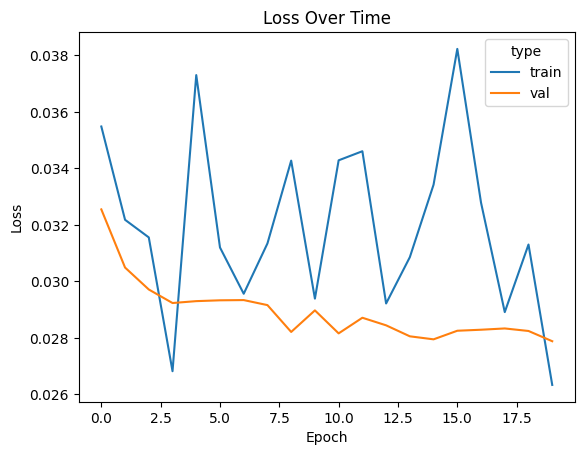

In [48]:
# plot loss, separate by train and val
sns.lineplot(data=df, x='epoch', y='loss', hue='type')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

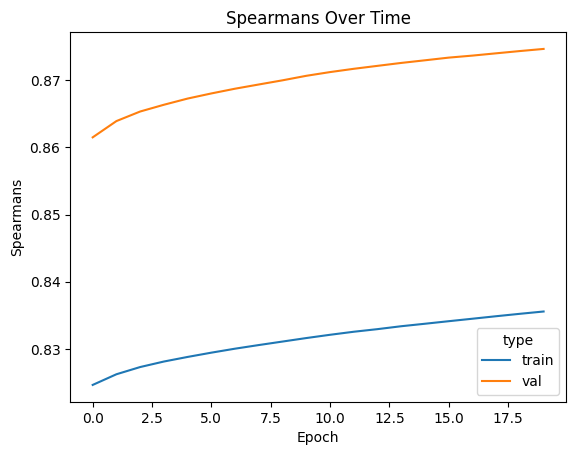

In [50]:
# plot spearmans, separate by train and val
sns.lineplot(data=df, x='epoch', y='accuracy', hue='type')
plt.title('Spearmans Over Time')
plt.xlabel('Epoch')
plt.ylabel('Spearmans')
plt.show()